## Prepare adata object

In [1]:
import scanpy as sc
import anndata as ad
from scipy import io
import numpy as np
import pandas as pd
import scvelo as scv
import cellrank as cr

In [2]:
scv.settings.verbosity = 2
scv.settings.presenter_view = True
scv.set_figure_params(facecolor='white',
                               dpi_save=600,
                               frameon=False,
                               vector_friendly=True,
                               figsize=(4,6),
                               transparent=True)
scv.settings.plot_prefix = 'infected/infected_'
cr.settings.verbosity = 2

In [3]:
# To match ggplot2 colours in Seurat:
main_celltype_palette={'Epithelial':'#F6766D','Fibroblast':'#A2A402',
                       'Immune':'#00BD7C','Neurons':'#00AEF4','Vascular':'#E46AF1'}

colour_palette={'Basal':"#F0A0FF", 'Dendritic cells':"#0075DC",
                'Endothelial cells':"#993F00", 'Fibroblast':"#4C005C",
                'Macrophages':"#191919", 'Memory T cells':"#005C31",
                'Neurons':"#2BCE48", 'Neutrophils':"#FFCC99",
                'Outer bulge': "#808080", 'Sebacious gland':"#94FFB5",
                'Suprabasal':"#8F7C00",
                'Upper hair follicle suprabasal':"#9DCC00",
                'Vascular smooth muscle':"#C20088"}

cluster_palette={'MAC1':"#aa0dfe", 'FIB1':"#3283fe",
                 'FIB2':"#85660d", 'BAS1':"#782ab6",
                 'SUP1':"#565656",'HFSUP1':"#1c8356",
                 'SG':"#16FF32", 'NEUT1':"#F7E1A0",
                 'SUP2':"#E2E2E2", 'MAC2':"#1CBE4F",
                 'SUP3':"#C4451C", 'EC1':"#DEA0FD",
                 'EC2':"#FE00FA", 'SUP4':"#325A9B",
                 'OB':"#FEAF16", 'FIB3':"#F8A19F",
                 'HFSUP2':"#90AD1C", 'DC':"#F6222E",
                 'VSM':"#1CFFCE", 'NEU':"#2ED9FF",
                 'NEUT2':"#B10DA1", 'BAS3':"#C075A6",
                 'TMEM':"#FC1CBF", 'BAS2':"#B00068"}

In [4]:
X = io.mmread("data/infected_counts.mtx")

In [5]:
adata = ad.AnnData(
    X=X.transpose().tocsr(), dtype=X.dtype
)

# load cell metadata pre-calculated in Seurat:
cell_meta = pd.read_csv("data/infected_metadata.csv")

# load gene names pre-calculated in Seurat:
with open("data/infected_gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

# load barcodes pre-calculated in Seurat:
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# load dimensional reduction pre-calculated in Seurat:
pca = pd.read_csv("data/infected_pca.csv")
pca.index = adata.obs.index

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


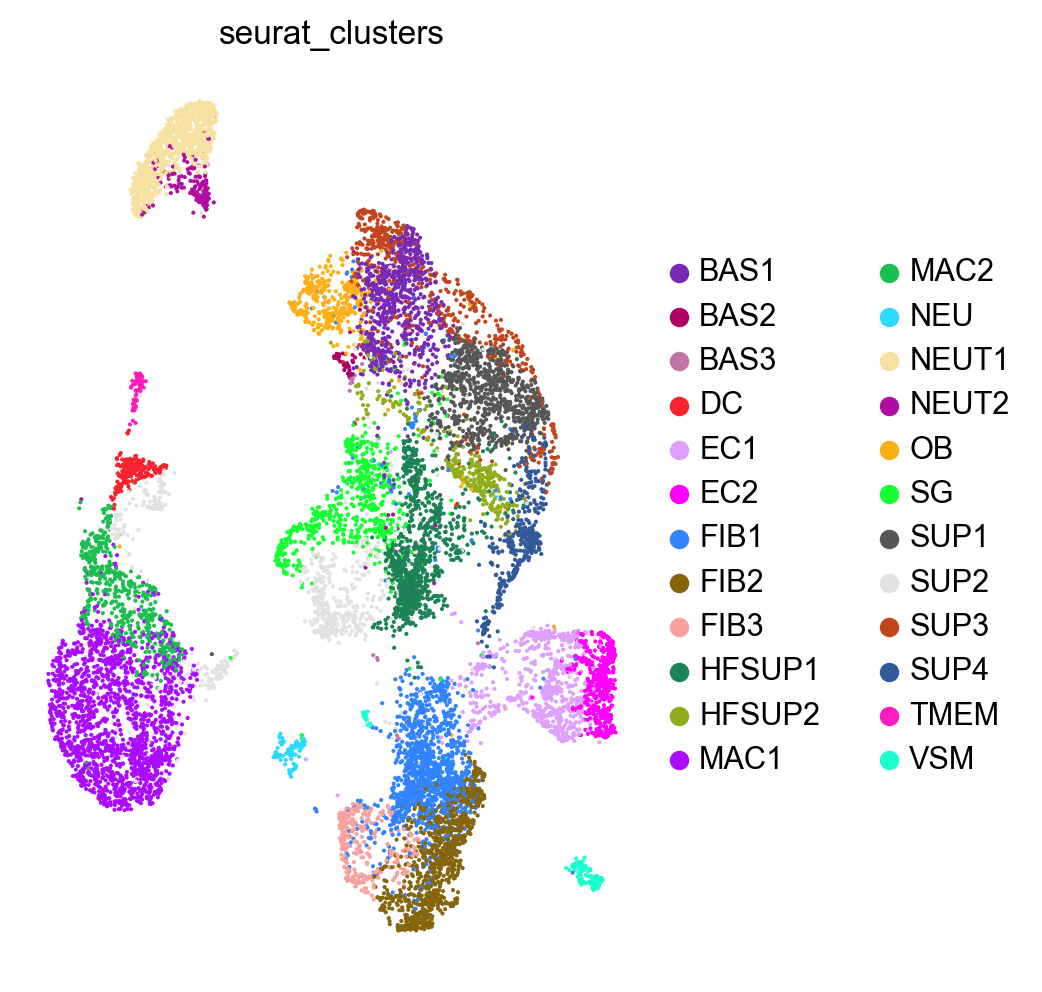

In [6]:
# set pca and umap pre-calculated in Seurat:
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

# plot a UMAP colored by celltypes to test:
sc.pl.umap(adata,
           color='seurat_clusters',
           frameon=False,
           palette=cluster_palette)

In [7]:
# read .loom files created in velocyto for each sample in the integrated dataset
ldata1 = scv.read('loom/infected_1.loom', cache=False, validate=False)
ldata2 = scv.read('loom/infected_2.loom', cache=False, validate=False)

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# rename barcodes in order to merge
barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_1' for bc in barcodes]
ldata1.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in ldata2.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_2' for bc in barcodes]
ldata2.obs.index = barcodes

In [9]:
ldata1.var_names_make_unique()
ldata2.var_names_make_unique()

In [10]:
# concatenate loom data
ldata = ldata1.concatenate(ldata2)

In [11]:
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(ldata)

In [12]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

# save dataset as anndata format
adata.write('adata/infected.h5ad')

# scVelo

saving figure to file ./figures/infected/infected_proportions_spliced_unspliced.pdf


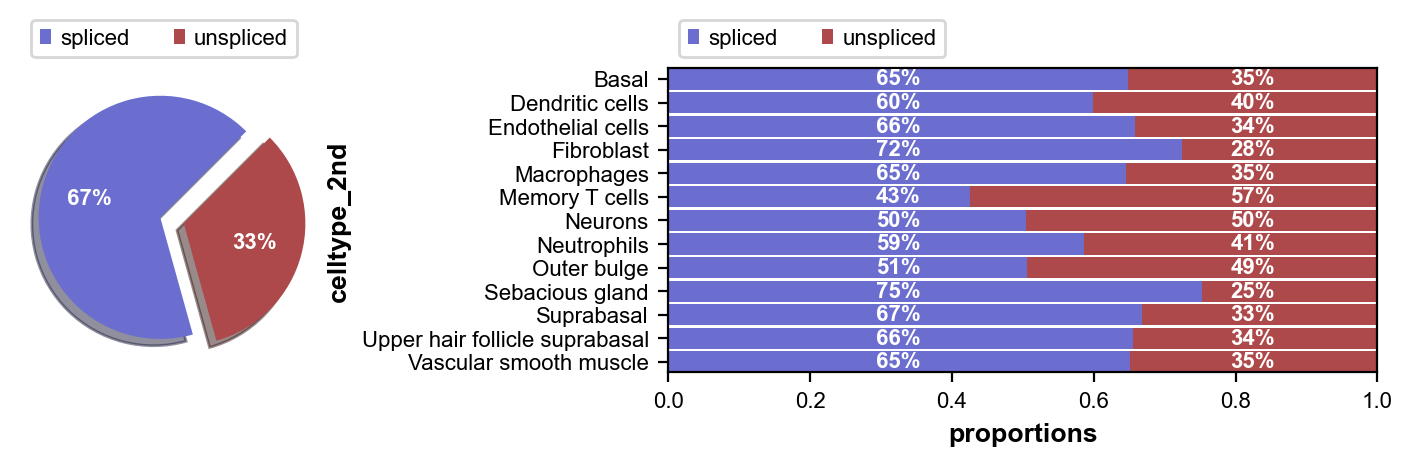

In [13]:
scv.pl.proportions(adata, groupby='celltype_2nd', save = 'spliced_unspliced.pdf')

## Dynamical model

In [14]:
#adata = scv.read('adata/infected.h5ad')

In [15]:
# immune cells
immune = ['MAC1', 'MAC2', 'DC', 'TMEM']
adata = adata[adata.obs['seurat_clusters'].isin(immune)]

In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=14, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 19758 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:00)


In [17]:
scv.tl.recover_dynamics(adata, n_jobs = 10)

recovering dynamics (using 10/12 cores)


  0%|          | 0/756 [00:00<?, ?gene/s]

    finished (0:01:04)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [18]:
scv.tl.velocity(adata, mode = 'dynamical', n_jobs = 10)
scv.tl.velocity_graph(adata, n_jobs = 10)

computing velocities
    finished (0:00:01)
computing velocity graph (using 10/12 cores)


  0%|          | 0/2526 [00:00<?, ?cells/s]

    finished (0:00:03)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


In [19]:
# save for later
#adata.write('processed_adata/infected.h5ad', compression='gzip')
adata = scv.read('processed_adata/infected.h5ad')

computing velocity embedding
    finished (0:00:00)
saving figure to file ./figures/infected/infected_immune_velocity_stream.svg


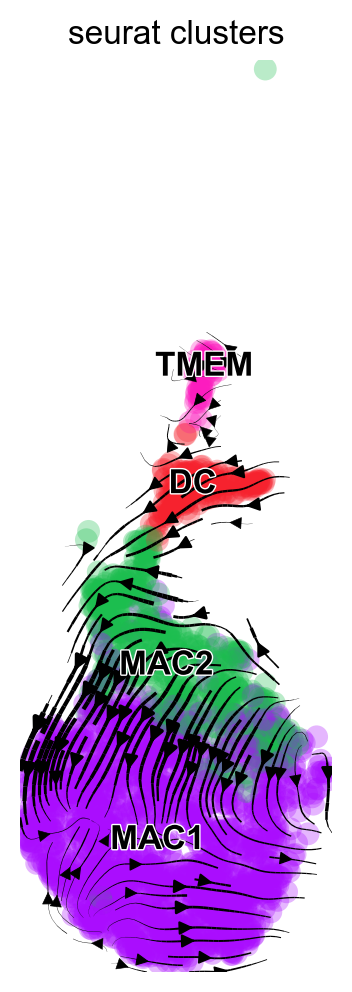

In [20]:
scv.pl.velocity_embedding_stream(adata,
                                 basis = 'umap',
                                 smooth = 0.8,
                                 min_mass = 2.5,
                                 color = 'seurat_clusters',
                                 figsize = (2,6),
                                 palette = cluster_palette,
                                 save = 'immune_velocity_stream.svg'
                                )

# CellRank

## Identify terminal states

In [21]:
cr.tl.terminal_states(adata,
                      cluster_key="seurat_clusters",
                      weight_connectivities=0.2)

Accessing `adata.obsp['T_fwd']`
Computing transition matrix based on logits using `'deterministic'` mode


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_5009/2206854306.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata,
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/2526 [00:00<?, ?cell/s]

Setting `softmax_scale=3.4931`


  0%|          | 0/2526 [00:00<?, ?cell/s]

    Finish (0:00:02)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:00)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file figures/infected/infected_immune_cellrank_terminal_states.pdf


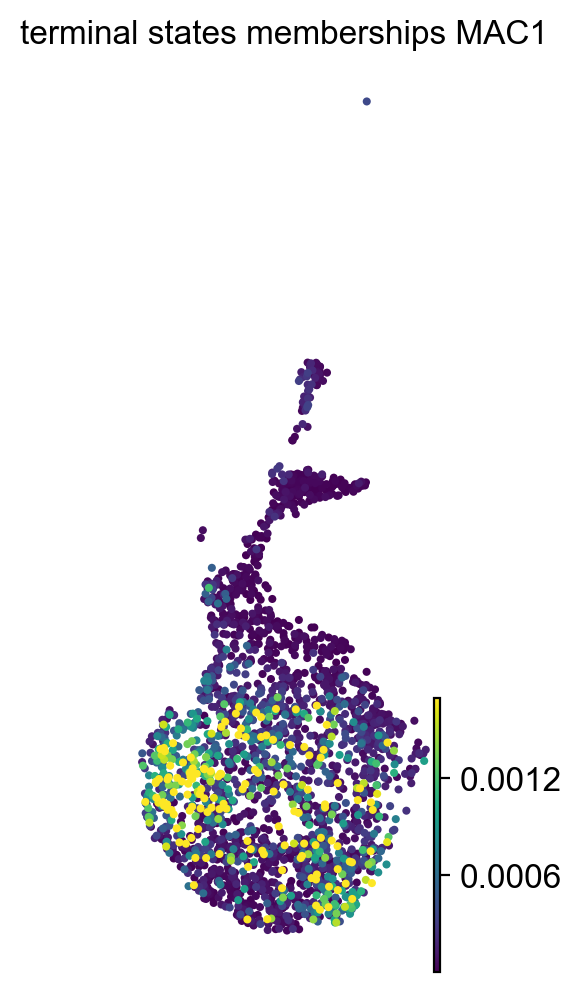

In [22]:
cr.pl.terminal_states(adata,
                      figsize = (2,6),
                      save = 'figures/infected/infected_immune_cellrank_terminal_states.pdf'
                      )

## Identify initial states

Accessing `adata.obsp['T_bwd']`
Computing transition matrix based on logits using `'deterministic'` mode


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_5009/569478924.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata,
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/2526 [00:00<?, ?cell/s]

Setting `softmax_scale=3.4931`


  0%|          | 0/2526 [00:00<?, ?cell/s]

    Finish (0:00:05)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_bwd']`
       `.eigendecomposition`
    Finish (0:00:00)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file figures/infected/infected_immune_cellrank_initial_states.pdf


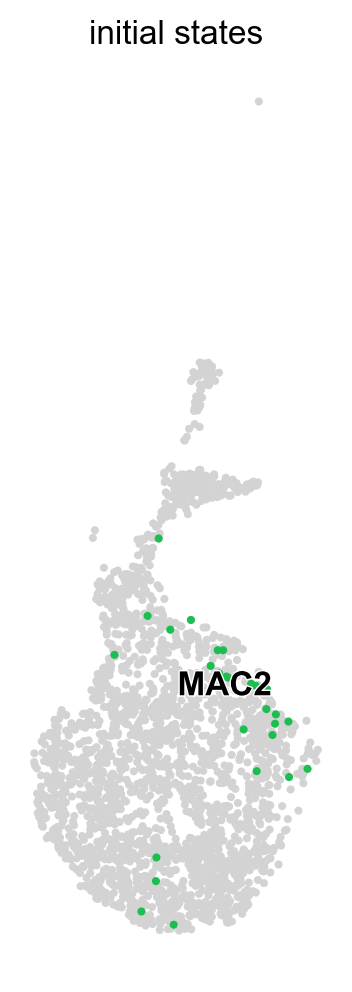

In [23]:
cr.tl.initial_states(adata,
                     cluster_key = 'seurat_clusters')

cr.pl.initial_states(adata,
                     discrete = True,
                     figsize = (2,6),
                     save = 'figures/infected/infected_immune_cellrank_initial_states.pdf'
                    )

Computing absorption probabilities
Defaulting to `'gmres'` solver.


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_5009/3092293206.py:2: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)


  0%|          | 0/1 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file figures/infected/infected_immune_cellrank_lineages.pdf


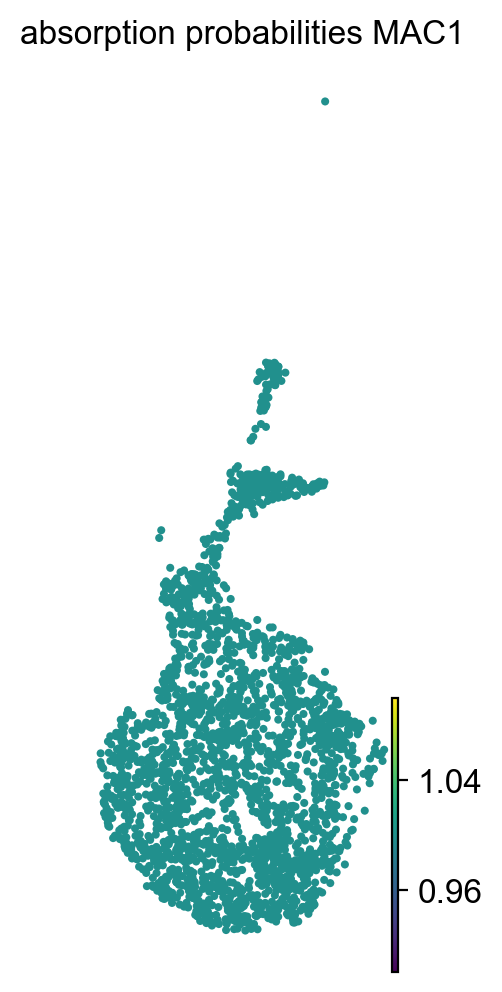

In [24]:
# Compute fate maps
cr.tl.lineages(adata)

cr.pl.lineages(adata,
               same_plot = False,
               figsize = (2,6),
               save = 'figures/infected/infected_immune_cellrank_lineages.pdf'
              )

In [25]:
# Directed PAGA
scv.tl.recover_latent_time(adata,
                           root_key="initial_states_probs",
                           end_key="terminal_states_probs")

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00)


In [26]:
scv.tl.paga(adata,
            groups="seurat_clusters",
            root_key="initial_states_probs",
            end_key="terminal_states_probs",
            use_time_prior="velocity_pseudotime")

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:00)


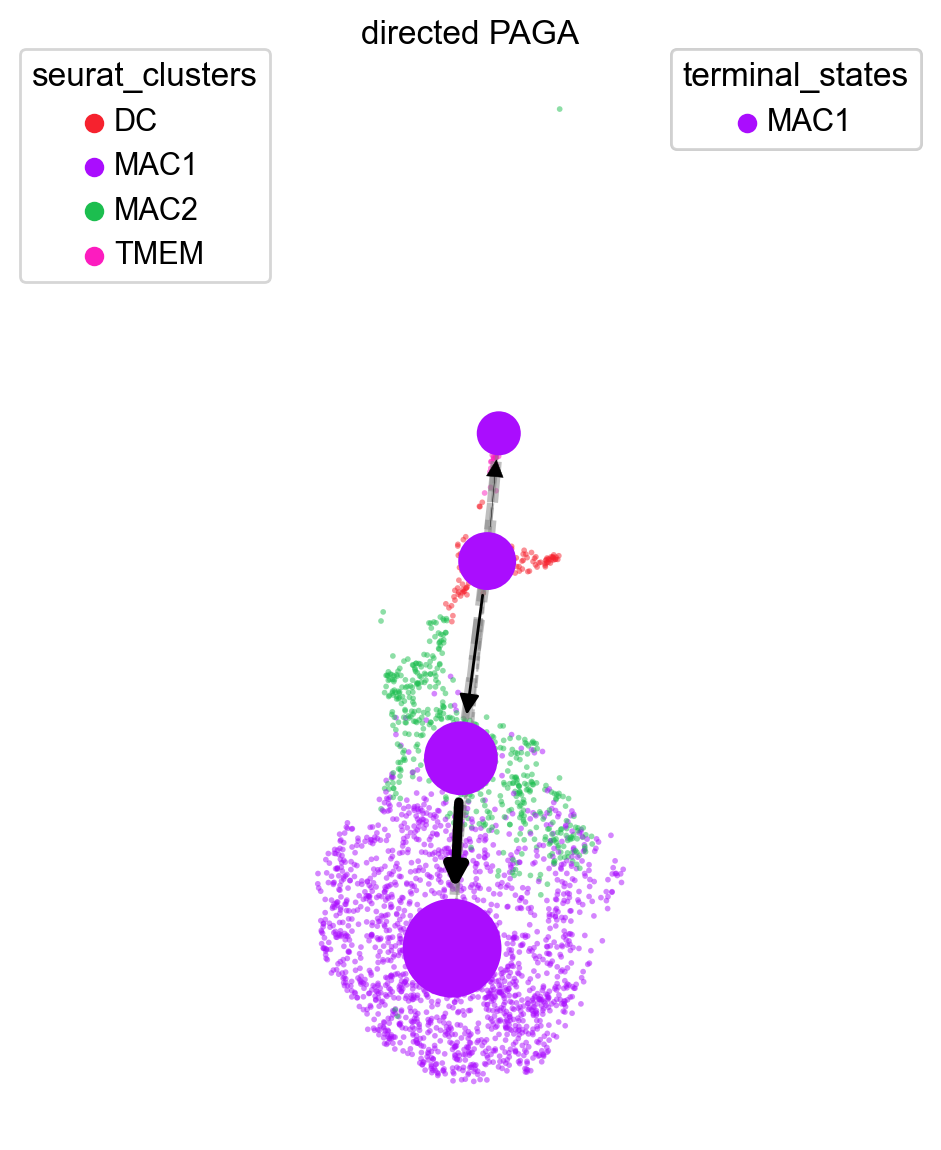

In [27]:
cr.pl.cluster_fates(adata,
                    mode="paga_pie",
                    cluster_key="seurat_clusters",
                    basis="umap",
                    legend_kwargs={"loc": "top right out"},
                    legend_loc="top left out",
                    node_size_scale=5,
                    edge_width_scale=1,
                    max_edge_width=4,
                    figsize = (2.5,6),
                    title="directed PAGA",
                    save = 'infected/infected_immune_cluster_fates.svg'
                   )

## Compute lineage drivers

In [28]:
cr.tl.lineage_drivers(adata,lineages='MAC1')

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


/var/folders/9b/399_qf9s3gz9j3f1l6bkpm0m0000gp/T/ipykernel_5009/346492268.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata,lineages='MAC1')


,MAC1_corr,MAC1_pval,MAC1_qval,MAC1_ci_low,MAC1_ci_high
Hmox1,0.563289,4.415115e-225,8.830231e-222,0.536065,0.589342
Prdx1,0.476102,3.315486e-149,3.315486e-146,0.445371,0.505712
Gclm,0.398680,9.388297e-100,6.258865e-97,0.365361,0.430980
Rnf128,0.283767,1.239075e-48,6.195373e-46,0.247506,0.319235
Ptgr1,0.236408,1.011157e-33,4.044627e-31,0.199244,0.272892
...,...,...,...,...,...
H2-DMa,-0.087780,9.845816e-06,1.514741e-04,-0.126348,-0.048947
Actb,-0.093432,2.516958e-06,4.360689e-05,-0.131951,-0.054630
Ifi27l2a,-0.101868,2.827610e-07,5.770634e-06,-0.140311,-0.063118
Cst3,-0.103785,1.677615e-07,3.646988e-06,-0.142210,-0.065048


### Top 12 driver genes for MAC1

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all functi

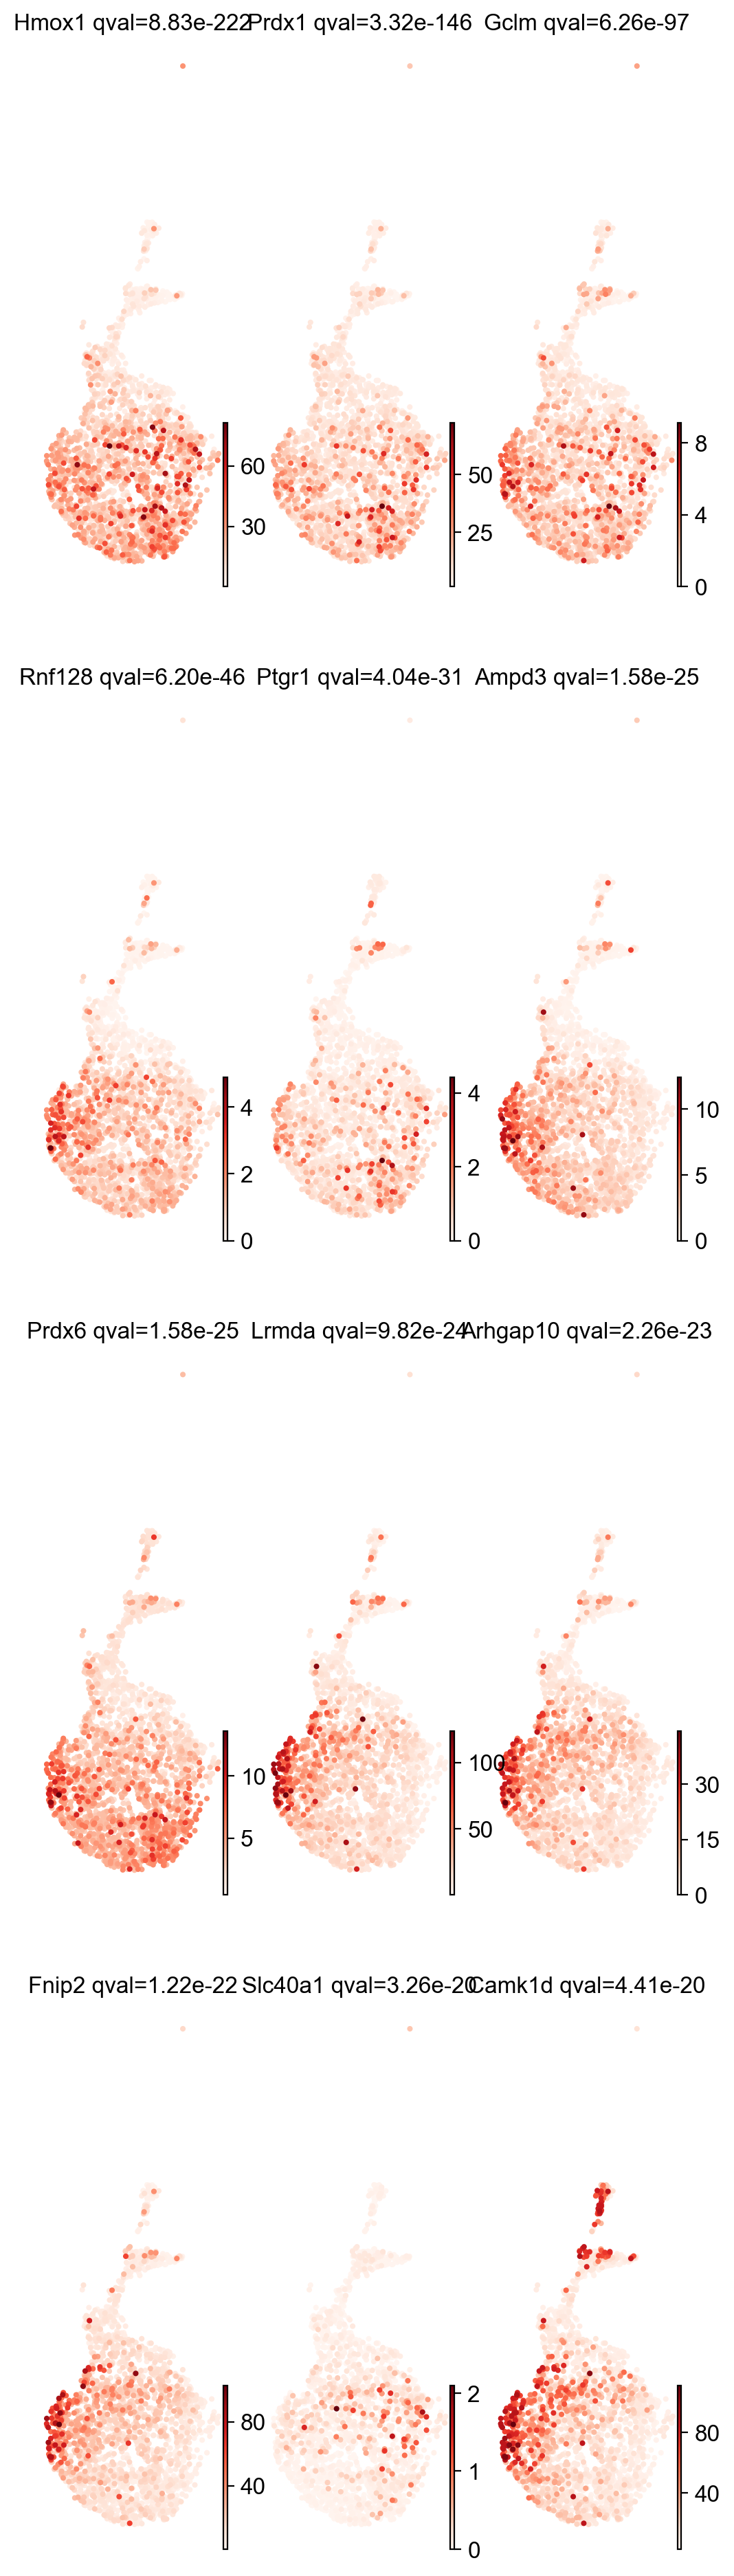

In [29]:
cr.pl.lineage_drivers(adata,
                      lineage = 'MAC1',
                      n_genes = 12,
                      ncols = 3,
                      figsize = (6,24),
                      title_fmt='{gene} qval={qval:.2e}',
                      save = 'infected/infected_immune_lineage_drivers_rescaled.pdf',
                      color_map = 'Reds',
                      smooth = True,
                      wspace = 5,
                     )

 ### Gene expression trends

In [30]:
## compute DPT, starting from CellRank defined root cell
root_idx = np.where(adata.obs["initial_states"] == "MAC2")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/cenk/.virtualenvs/rna_velocity/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ./figures/infected/infected_immune_root_latent_dpt.pdf


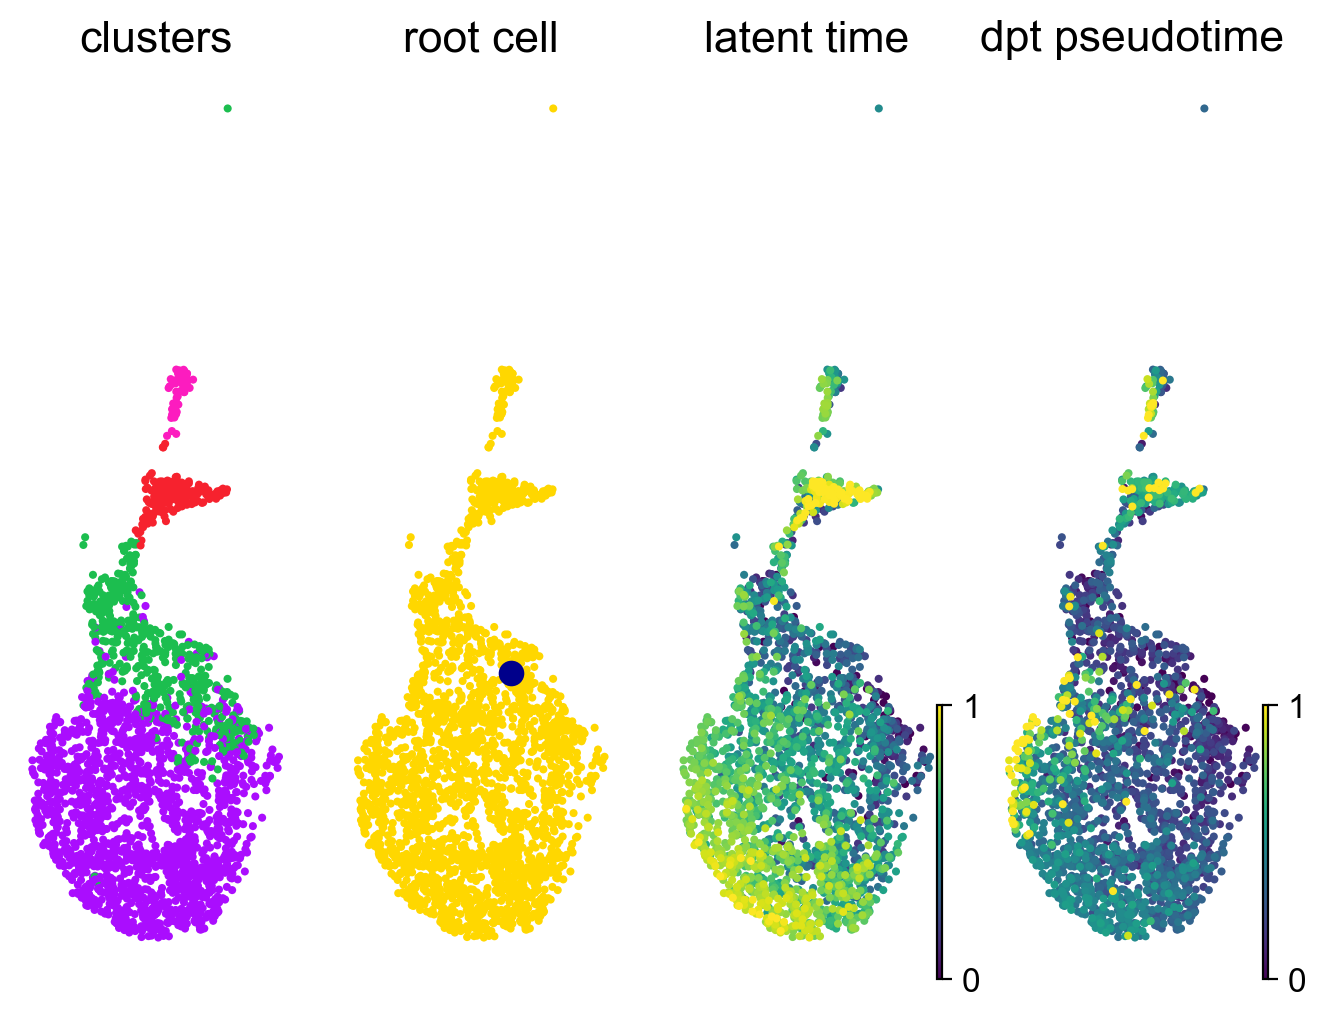

In [31]:
scv.pl.scatter(adata,
               color = ["seurat_clusters", root_idx, "latent_time", "dpt_pseudotime"],
               fontsize = 16,
               cmap = "viridis",
               perc = [2, 98],
               colorbar = True,
               rescale_color = [0, 1],
               figsize = (2,6),
               title = ["clusters", "root cell", "latent time", "dpt pseudotime"],
               save = 'immune_root_latent_dpt.pdf'
              )

In [32]:
model = cr.ul.models.GAM(adata)

In [ ]:
genes = adata.varm['terminal_lineage_drivers']["MAC1_corr"].sort_values(ascending=False).index[:12]

cr.pl.gene_trends(adata,
                  model = model,
                  data_key = "Ms",
                  genes = genes,
                  lineages = 'MAC1',
                  time_key = "latent_time",
                  same_plot = False,
                  hide_cells = False,
                  show_progress_bar = False,
                  figsize = (3, 15),
                  gene_as_title = True,
                  cell_color = 'latent_time',
                  n_jobs = 10,
                  time_range=[(0,0.6)],
                  save = 'infected/infected_immune_gene_trends.pdf'
                 )

Computing trends using `10` core(s)


  0%|          | 0/12 [00:00<?, ?gene/s]

    Finish (0:00:19)
Plotting trends


In [ ]:
cr.pl.heatmap(adata,
              model,
              genes = adata.varm['terminal_lineage_drivers']["MAC1_corr"].sort_values(ascending=False).index[:30],
              show_absorption_probabilities = True,
              lineages = "MAC1",
              n_jobs = 1,
              backend = "loky",
              figsize = (10,10),
              save = 'infected/infected_immune_terminal_lineage_drivers.pdf'
             )

In [ ]:
cr.pl.heatmap(adata,
              model,
              adata.var_names[:30],
              time_key = 'latent_time',
              lineages = 'MAC1',
              show_progress_bar = False,
              show_absorption_probabilities = True,
              figsize = (10, 10),
              save ='infected/infected_immune_latent_time.pdf',
              return_genes = False)

In [ ]:
cr.pl.cluster_fates(adata, mode = "violin",
                    cluster_key = "seurat_clusters",
                    lineages = 'MAC1',
                    figsize = (3,2),
                    save = 'infected/infected_immune_aggregated_cluster_fates.pdf'
                   )

In [ ]:
cr.pl.cluster_fates(adata,
                    cluster_key = 'seurat_clusters',
                    figsize=(5,3),
                    mode="clustermap",
                    save='infected/infected_immune_aggregated_cluster_fates_heatmap.pdf')

In [ ]:
counts_s = scv.utils.sum_var(adata.layers['spliced'])
counts_u = scv.utils.sum_var(adata.layers['unspliced'])
fractions_u = counts_u / (counts_s + counts_u)
scv.pl.scatter(adata, color=fractions_u, smooth=True, save='splicing.pdf',color_map='Reds',figsize=(2,6))

In [ ]:
genes = adata.varm['terminal_lineage_drivers']["MAC1_corr"].sort_values(ascending=False).index[:50]
scv.tl.differential_kinetic_test(adata, var_names=genes, groupby='seurat_clusters')

In [ ]:
scv.get_df(adata[:, genes], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

In [ ]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata, basis=genes[:20], add_outline='fit_diff_kinetics', **kwargs, ncols=4, figsize=(4,5))

In [ ]:
scv.pl.scatter(adata, basis=genes[20:40], add_outline='fit_diff_kinetics', **kwargs, ncols=4, figsize=(4,5))

In [ ]:
scv.pl.scatter(adata, basis=genes[40:50], add_outline='fit_diff_kinetics', **kwargs, ncols=4, figsize=(4,3))

In [ ]:
diff_clusters=list(adata[:, genes].var['fit_diff_kinetics'])

scv.pl.scatter(adata, legend_loc='right', size=60, title='diff kinetics',
               add_outline=diff_clusters, outline_width=(.8, .2), color='seurat_clusters', figsize=(2,6),
               save='diff_kinetics.pdf')

In [ ]:
# top-likelihood genes
scv.tl.recover_dynamics(adata, n_jobs=10)
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='seurat_clusters')

In [ ]:
scv.pl.scatter(adata, basis=top_genes[:15], ncols=4, add_outline='fit_diff_kinetics', **kwargs, save='top_likelihood_15')

In [ ]:
scv.pl.scatter(adata, basis=top_genes[15:30], ncols=4, add_outline='fit_diff_kinetics', **kwargs,save='top_likelihood_30')

In [ ]:
scv.tl.velocity(adata, diff_kinetics=True)
scv.tl.velocity_graph(adata)

In [ ]:
scv.pl.velocity_embedding_stream(adata,
                                 basis = 'umap',
                                 smooth = 0.8,
                                 min_mass = 2.5,
                                 color = 'seurat_clusters',
                                 figsize = (2,6),
                                 palette = cluster_palette,
                                 save = 'immune_velocity_stream_diff_kinetics.svg'
                                )

In [ ]:
import session_info
session_info.show()